## Подгрузка нужных библиотек и датасетов

In [ ]:
!pip install pandas numpy matplotlib seaborn

In [129]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
%matplotlib inline

import seaborn as sns
sns.set() # устанавливаем seaborn как по-умолчанию для отрисовки графиков

train = pd.read_csv('data/train.csv')
test = pd.read_csv('data/test.csv')
train_test_data = [train, test]

## Пропущенные значения

In [130]:
for data in train_test_data:
    print(data.isnull().sum())

PassengerId       0
HomePlanet      201
CryoSleep       217
Cabin           199
Destination     182
Age             179
VIP             203
RoomService     181
FoodCourt       183
ShoppingMall    208
Spa             183
VRDeck          188
Name            200
Transported       0
dtype: int64
PassengerId       0
HomePlanet       87
CryoSleep        93
Cabin           100
Destination      92
Age              91
VIP              93
RoomService      82
FoodCourt       106
ShoppingMall     98
Spa             101
VRDeck           80
Name             94
dtype: int64


Проверим распределение пропущенныйх HomePlanet на Transported

<Axes: xlabel='Destination', ylabel='Count'>

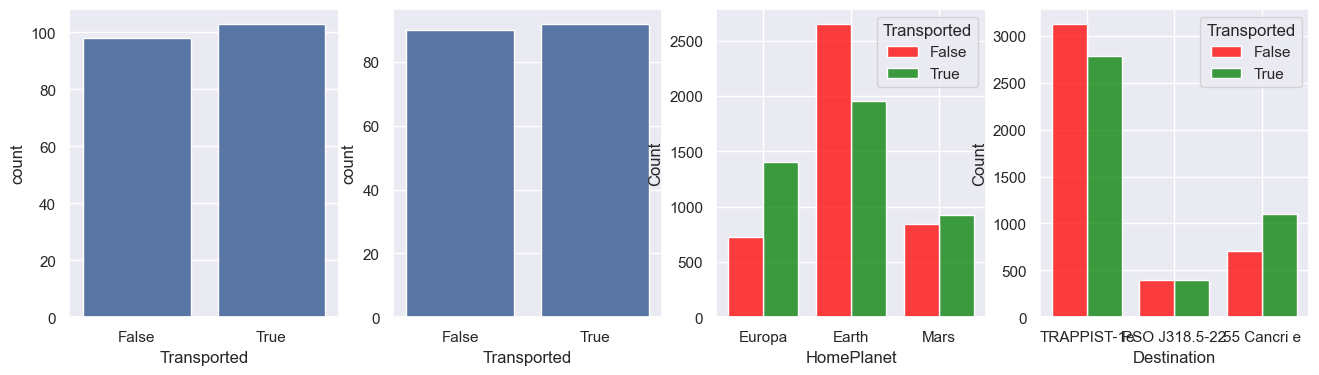

In [131]:
fig_0 = plt.figure(figsize=(16,4))
ax_0 = fig_0.add_subplot(141)
ax_1 = fig_0.add_subplot(142)
ax_2 = fig_0.add_subplot(143)
ax_3 = fig_0.add_subplot(144)

# Фильтруем только строки с пропущенными значениями HomePlanet
missing_data_HomePlanet = train[train['HomePlanet'].isna()]
sns.countplot(x='Transported', data=missing_data_HomePlanet, ax=ax_0)

# Фильтруем только строки с пропущенными значениями Destination
missing_data_Destination = train[train['Destination'].isna()]
sns.countplot(x='Transported', data=missing_data_Destination,ax=ax_1)

sns.histplot(
    data=train,
    x='HomePlanet',
    hue='Transported',
    multiple='dodge',  # Столбцы рядом друг с другом
    shrink=0.8,        # уменьшаем ширину столбцов для лучшего разделения
    palette={True: 'green', False: 'red'},
    ax = ax_2
)
sns.histplot(
    data=train,
    x='Destination',
    hue='Transported',
    multiple='dodge',
    shrink=0.8,
    palette={True: 'green', False: 'red'},
    ax = ax_3
)

Для HomePlanet и Destination влияние на Transported почти 50/50. Это больше всего похоже на соотношение для Mars и PSO J318.5-22 соответсвенно. Поэтому можем выбрать их для заполнения Nan. Или выделить отдельный вариант 'Unknown'. Эти варианты будут давать минимальное смещение. Выберу второй.

In [132]:
for data in train_test_data:
    data['HomePlanet'] = data['HomePlanet'].fillna('Unknown')
    data['Destination'] = data['Destination'].fillna('Unknown')

Возраст заполняем случайными значениями в возрастном промежутке от max_age до min_age

In [133]:
for data in train_test_data:
    min_age = data['Age'].min()
    max_age = data['Age'].max()

    # индексы пропущенных значений
    missing_age_indices = data['Age'].isna()

    random_ages = np.random.uniform(min_age, max_age, size=missing_age_indices.sum())

    data.loc[missing_age_indices, 'Age'] = random_ages

    # Округляем до целых чисел
    data['Age'] = data['Age'].round().astype(int)

Cabin тоже заполним 'Unknown', т.к. заполнение модой по стороне борта может сделать смещение по результатам. А deck/num крайне сложно угадать, поэтому их указывать тоже не будем.

In [134]:
for data in train_test_data:
    # Для каюты создаем категорию "Unknown"
    data['Cabin'] = data['Cabin'].fillna('Unknown/Unknown/Unknown')

Проверим отношение незаполненных Cryosleep and VIP к Transported:

<Axes: xlabel='Transported', ylabel='count'>

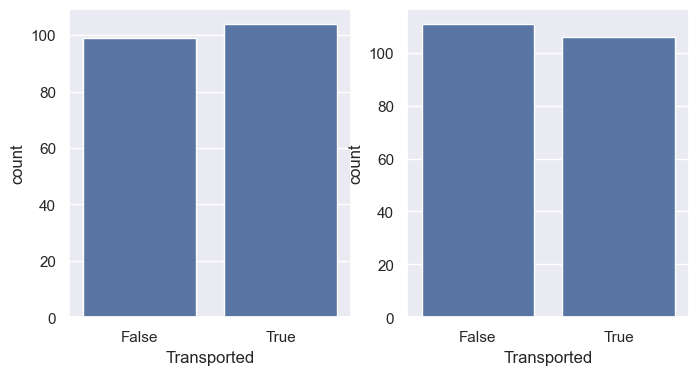

In [135]:
fig_2 = plt.figure(figsize=(8,4))
ax2_0 = fig_2.add_subplot(121)
ax2_1 = fig_2.add_subplot(122)


# Фильтруем только строки с пропущенными значениями Destination
missing_data_VIP = train[train['VIP'].isna()]
sns.countplot(x='Transported', data=missing_data_VIP,ax=ax2_0)

# train['Cryosleep'] = train['Cryosleep'].fillna('Unknown')
missing_data_Cryosleep = train[train['CryoSleep'].isna()]
sns.countplot(x='Transported', data=missing_data_Cryosleep, ax=ax2_1)

Примерно поровну, поэтому заполним случайными значениями в соответсвии с общим распределением true и false для CryoSleep и VIP.

In [136]:
for data in train_test_data:
    # Проверим общее распределение CryoSleep
    cryo_distribution = data['CryoSleep'].value_counts(normalize=True)

    # Заполним пропуски случайными значениями в соответствии с общим распределением
    missing_mask = data['CryoSleep'].isna()
    n_missing = missing_mask.sum()

    # Генерируем случайные значения согласно распределению
    random_values = np.random.choice(
        [True, False],
        size=n_missing,
        p=[cryo_distribution.get(True, 0.5), cryo_distribution.get(False, 0.5)]
    )

    data.loc[missing_mask, 'CryoSleep'] = random_values

    # То же для VIP
    VIP_distribution = data['VIP'].value_counts(normalize=True)

    missing_mask_VIP = data['VIP'].isna()
    n_missing_VIP = missing_mask_VIP.sum()

    # Генерируем случайные значения согласно распределению
    random_values_VIP = np.random.choice(
        [True, False],
        size=n_missing_VIP,
        p=[VIP_distribution.get(True, 0.5), VIP_distribution.get(False, 0.5)]
    )

    data.loc[missing_mask_VIP, 'VIP'] = random_values_VIP

Расходные признаки заполним нулями:

In [137]:
for data in train_test_data:
    # Для расходных признаков заполняем нулями
    expense_cols = ['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']
    for col in expense_cols:
        data[col] = data[col].fillna(0)

Поле Name никак не влияет на перемещение в параллельную вселенную, поэтому его вообще удалим. И проверим наличие пустых значений после нашей чисткт'

In [138]:
for data in train_test_data:
    # Удаляем столбец с именами
    data.drop('Name', axis=1, inplace=True)

    # Проверяем, что все пропуски заполнены
    print(data.isnull().sum())

PassengerId     0
HomePlanet      0
CryoSleep       0
Cabin           0
Destination     0
Age             0
VIP             0
RoomService     0
FoodCourt       0
ShoppingMall    0
Spa             0
VRDeck          0
Transported     0
dtype: int64
PassengerId     0
HomePlanet      0
CryoSleep       0
Cabin           0
Destination     0
Age             0
VIP             0
RoomService     0
FoodCourt       0
ShoppingMall    0
Spa             0
VRDeck          0
dtype: int64


## Анализ данных

Посмотрим на зависимость Transported от некоторых столбцов:
1) Cryosleep - Большая часть True переместилась в параллельную вселенную, в False - меньшая
2) VIP - Примерно половина False переместилась в параллельную вселенную, True - меньше 40%
3) Transported для всех HomePlanet и Destination отличается, важно это учесть

<Axes: xlabel='Destination', ylabel='Transported'>

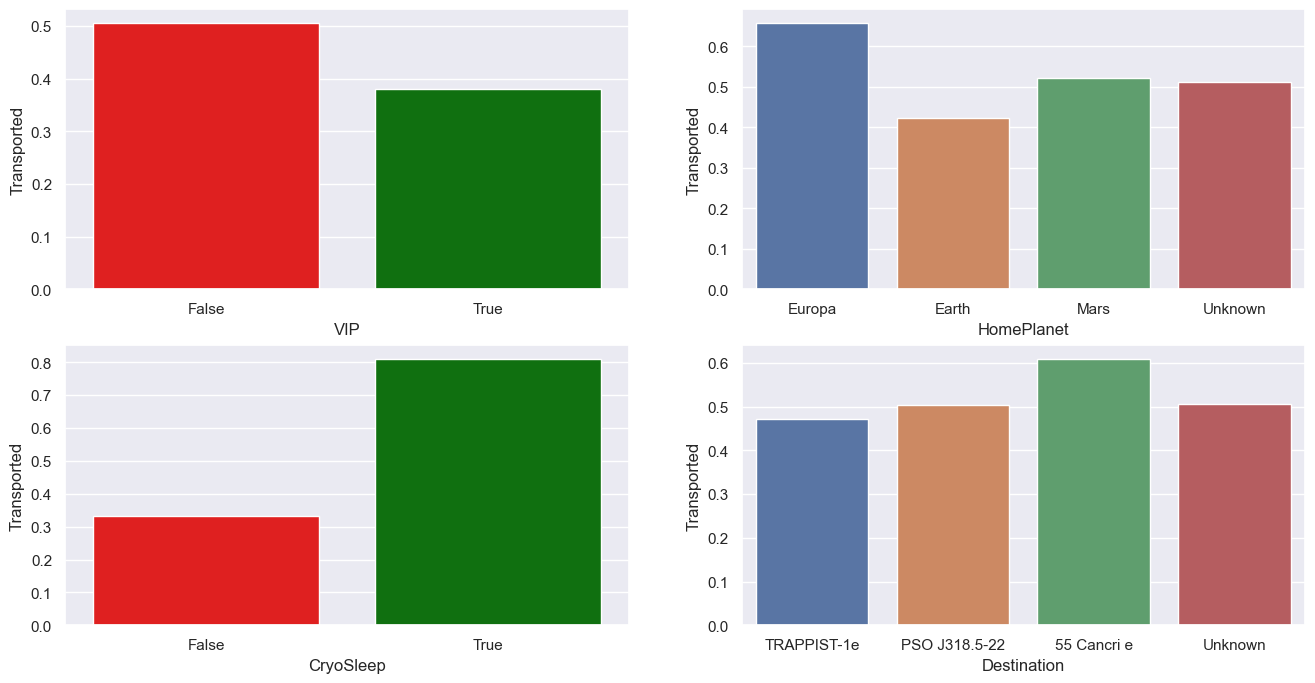

In [139]:
fig = plt.figure(figsize=(16,8))
ax1 = fig.add_subplot(221)
ax2 = fig.add_subplot(222)
ax3 = fig.add_subplot(223)
ax4 = fig.add_subplot(224)
sns.barplot(x='VIP', y='Transported',hue='VIP',legend=False, data=train, errorbar=None, ax=ax1, palette={True: 'green', False: 'red'}) # hue для требований seaborn, и отключаем легенду для исключения дублирования
sns.barplot(x='HomePlanet', y='Transported',hue='HomePlanet',legend=False, data=train, errorbar=None, ax=ax2)
sns.barplot(x='CryoSleep', y='Transported',hue='CryoSleep',legend=False, data=train, errorbar=None, ax=ax3, palette={True: 'green', False: 'red'})
sns.barplot(x='Destination', y='Transported',hue='Destination',legend=False, data=train, errorbar=None, ax=ax4)

Посмотрим на зависимость от трат на доп услуги:

Замечаем, что чем больше расходы, тем меньше становится отношение неперемещённых к перемещённым.
Исключением является категория людей, не приобритавших доп услуги - в этой категории перемещённых в параллельную вселенную намного больше.


<Axes: xlabel='ExpenseCategory', ylabel='Count'>

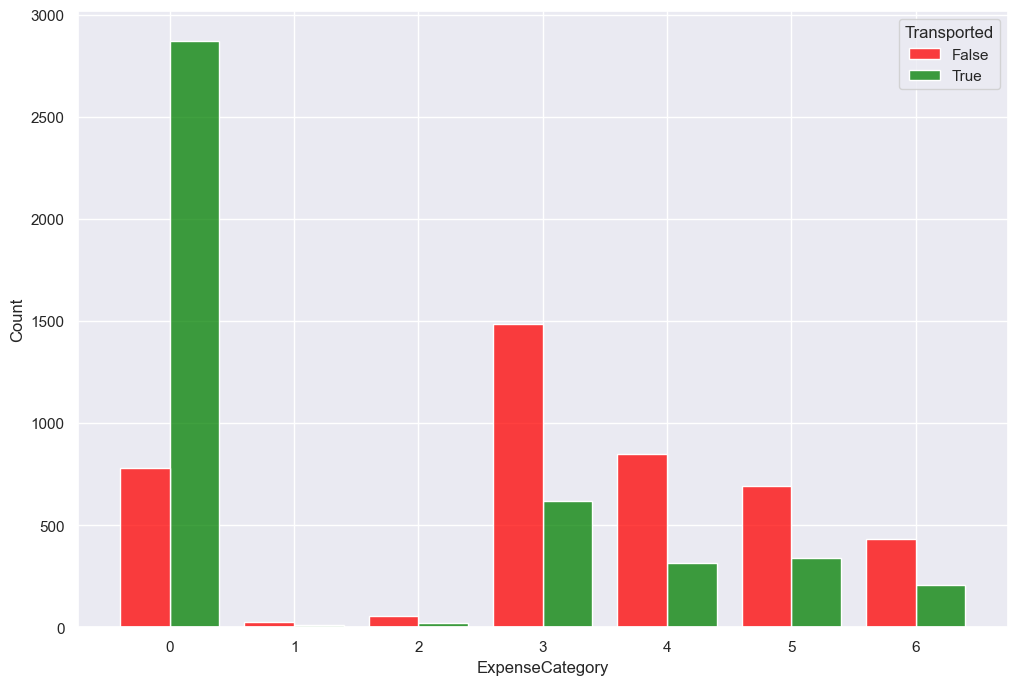

In [140]:
for data in train_test_data:
    # Создаем столбец с общей суммой расходов
    data['TotalExpense'] = data[['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']].sum(axis=1)

    # Создаем категории расходов
    bins = [-1, 0, 100, 500, 1000, 2000, 5000, float('inf')]
    labels = [0, 1, 2, 3, 4, 5, 6]
    data['ExpenseCategory'] = pd.cut(data['TotalExpense'], bins=bins, labels=labels)

plt.figure(figsize=(12, 8))

sns.histplot(
    data=train,
    x='ExpenseCategory',
    hue='Transported',
    multiple='dodge',  # Столбцы рядом друг с другом
    shrink=0.8,        # уменьшаем ширину столбцов для лучшего разделения
    palette={True: 'green', False: 'red'}
)

Теперь посмотрим на корреляцию расходов на отдельные доп услуг. Может спа было рядом с порталом?
Предварительно перобразуем столбец из True и False в 1 и 0.

<Axes: >

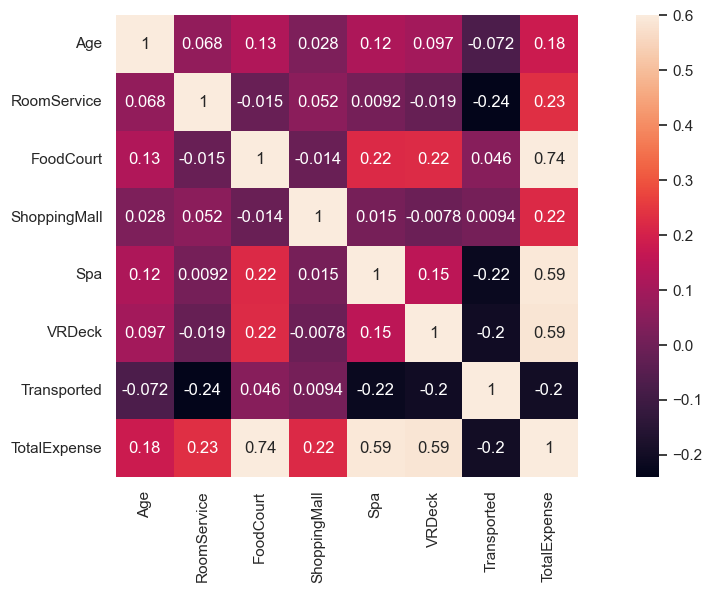

In [141]:
# Преобразование True/False в 1/0
train['Transported'] = train['Transported'].astype(int)

# Выберем только числовые колонки для корреляционного анализа
numeric_columns = train.select_dtypes(include=[np.number]).columns

# Вычислим корреляционную матрицу только для числовых данных
corr_matrix = train[numeric_columns].corr()

plt.figure(figsize=(15,6))
sns.heatmap(corr_matrix, vmax=0.6, square=True, annot=True)

Замечаем, что RoomService,Spa,VRDeck отрицательно влияют на выживаемость. Добавим столбцы is_Spa, is_VRDeck, is_RoomService.

In [142]:
for data in train_test_data:
    # Создаем бинарные признаки для расходов
    data['is_RoomService'] = (data['RoomService'] > 0).astype(int)
    data['is_Spa'] = (data['Spa'] > 0).astype(int)
    data['is_VRDeck'] = (data['VRDeck'] > 0).astype(int)


Приступим к анализу влияния возраста

<Axes: xlabel='Transported', ylabel='Age'>

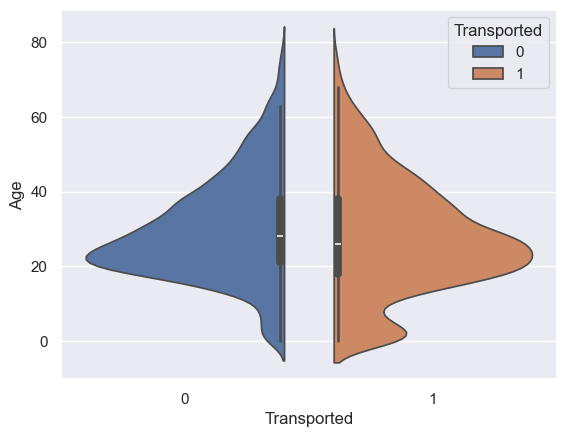

In [143]:
sns.violinplot(x="Transported", y="Age", hue="Transported", data=train, split=True)

Замечаем, что целевые группы среди перемещённых -  дети и люди молодого-среднего возраста. Поделим на группы по возрасту.

<Axes: xlabel='AgeCategory', ylabel='Count'>

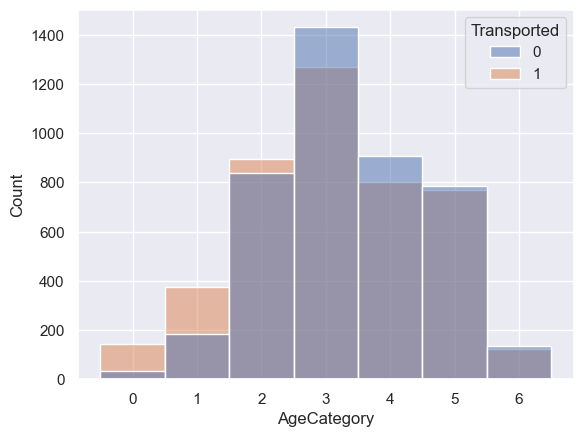

In [144]:
bins = [-1, 0, 10, 20, 30,40,60,80,100]
labels = [0, 1, 2, 3, 4, 5, 6,7]

for data in train_test_data:
    data['AgeCategory'] = pd.cut(data['Age'], bins=bins, labels=labels)

sns.histplot(
    data=train,
    x='AgeCategory',
    hue='Transported',
)

Проанализируем зависимость от расположения каюты. Сначала разделим на людей по типу каюты: P для Port, S для Starboard.
Строим график и замечаем, что:
БОльшая часть людей с кабинами типа S переместились в параллельную вселенную. А с кабинами P - нет.
Далее извлечём deck и num в отдельные столбцы и сделаем матрицу корреляции. Заметим, что есть небольшая зависимость от этих признаков.

<Axes: >

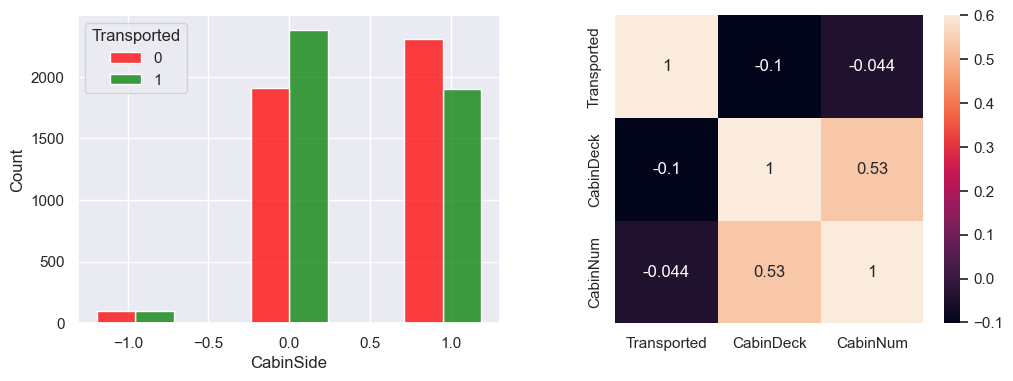

In [145]:
for data in train_test_data:
    # Извлекаем тип каюты
    cabin_types = data['Cabin'].str.split('/').str[2]
    cabin_deck = data['Cabin'].str.split('/').str[0]
    cabin_num = data['Cabin'].str.split('/').str[1]

    data['CabinSide'] = -1  # Значение по умолчанию для Unknown и других типов
    data.loc[cabin_types == 'P', 'CabinSide'] = 1
    data.loc[cabin_types == 'S', 'CabinSide'] = 0

    data['CabinDeck'] = cabin_deck.apply(lambda x: ord(x.upper()) - ord('A') + 1 if x != 'Unknown' else -1)
    data['CabinNum'] = cabin_num.apply(lambda x: x if x != 'Unknown' else -1)


fig4 = plt.figure(figsize=(12, 4))
ax4_0 = fig4.add_subplot(121)
ax4_1 = fig4.add_subplot(122)

sns.histplot(
    data=train,
    x='CabinSide',
    hue='Transported',
    multiple='dodge',  # Столбцы рядом друг с другом
    shrink=5,        # уменьшаем ширину столбцов для лучшего разделения
    palette={True: 'green', False: 'red'},
    ax = ax4_0
)
# Выберем только числовые колонки для корреляционного анализа
cabin_columns = ['Transported', 'CabinDeck', 'CabinNum']

# Вычислим корреляционную матрицу только для числовых данных
corr_matrix_cabin = train[cabin_columns].corr()

sns.heatmap(corr_matrix_cabin, vmax=0.6, square=True, annot=True, ax = ax4_1)

Проанализируем зависимость транспортировки от принадлежности к группе:

Выясняем, что у одиночек шанс переместится больше.

<Axes: xlabel='is_alone', ylabel='Transported'>

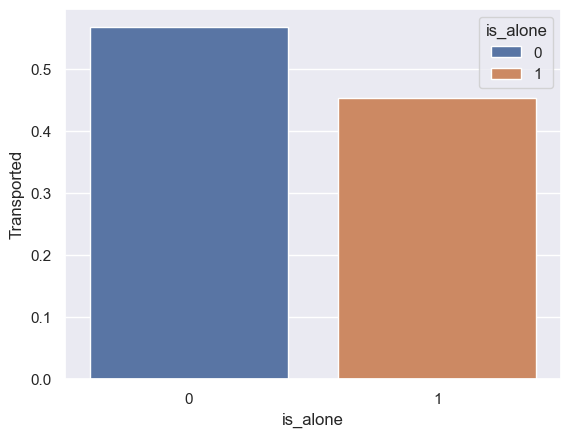

In [146]:
for data in train_test_data:
    # Извлекаем номер группы
    groupID = data['PassengerId'].str.split('_').str[0]
    data['groupID'] = groupID

    # Считаем количество пассажиров в каждой группе
    group_sizes = data['groupID'].value_counts()

    # Создаем столбец is_alone: 1 если пассажир один в группе, 0 если в группе
    data['is_alone'] = (data['groupID'].map(group_sizes) == 1).astype(int)

sns.barplot(x='is_alone', y='Transported', hue='is_alone', data=train, errorbar=None)

## Чистка ненужных столбцов и типизация данных

Столбец Name мы уже убрали.

Убираем PassengerId.

Вместо Age мы сделали AgeCategory - убираем

Из Cabin мы извлекли все нужные данные - убираем

Для RoomService,Spa,VRDeck мы сделали отдельные столбцы о существовании - убираем

Вместо TotalExpense мы ввели ExpenseCategory - убираем


In [147]:
train.drop(['PassengerId'], axis=1,inplace=True)
for data in train_test_data:
    data.drop(['Age'], axis=1,inplace=True)
    data.drop(['Cabin'], axis=1,inplace=True)
    data.drop(['RoomService'], axis=1,inplace=True)
    data.drop(['Spa'], axis=1,inplace=True)
    data.drop(['VRDeck'], axis=1,inplace=True)
    data.drop(['TotalExpense'], axis=1,inplace=True)

Преобразуем HomePlanet, CryoSleep, Destination, VIP в численный тип.

In [149]:
HomePlanet_mapping = {'Europa': 0, 'Mars': 1, 'Earth': 2, 'Unknown': 3}
Destination_mapping = {'TRAPPIST-1e': 0, 'PSO J318.5-22': 1, '55 Cancri e': 2, 'Unknown':3}

for data in train_test_data:
    data['CryoSleep'] = data['CryoSleep'].astype(int)
    data['VIP'] = data['VIP'].astype(int)

    data['HomePlanet'] = data['HomePlanet'].map(HomePlanet_mapping)
    data['Destination'] = data['Destination'].map(Destination_mapping)

In [151]:
test.head(10)

,PassengerId,HomePlanet,CryoSleep,Destination,VIP,FoodCourt,ShoppingMall,ExpenseCategory,is_RoomService,is_Spa,is_VRDeck,AgeCategory,CabinSide,CabinDeck,CabinNum,groupID,is_alone
0,0013_01,2,1,0,0,0.0,0.0,0,0,0,0,3,0,7,3,0013,1
1,0018_01,2,0,0,0,9.0,0.0,5,0,1,0,2,0,6,4,0018,1
2,0019_01,0,1,2,0,0.0,0.0,0,0,0,0,4,0,3,0,0019,1
3,0021_01,0,0,0,0,6652.0,0.0,6,0,1,1,4,0,3,1,0021,1
4,0023_01,2,0,0,0,0.0,635.0,3,1,0,0,2,0,6,5,0023,1
5,0027_01,2,0,0,0,1615.0,263.0,5,0,1,1,4,1,6,7,0027,1
6,0029_01,0,1,2,0,0.0,0.0,0,0,0,0,3,1,2,2,0029,1
7,0032_01,0,1,0,0,0.0,0.0,0,0,0,0,2,0,4,0,0032,0
8,0032_02,0,1,2,0,0.0,0.0,0,0,0,0,3,0,4,0,0032,0
9,0033_01,2,0,2,0,639.0,0.0,3,0,0,0,3,0,6,7,0033,1


## Тренировка и прогноз

In [ ]:
!pip install scikit-learn

In [157]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

x_train = train.drop('Transported', axis=1)
y_train = train['Transported']

x_test = test.drop("PassengerId", axis=1).copy()

x_train.shape, y_train.shape, x_test.shape
clf = RandomForestClassifier(n_estimators=100)
clf.fit(x_train, y_train)
y_test = clf.predict(x_test)

In [164]:
submission = pd.DataFrame({
    "PassengerId": test['PassengerId'],
    "Transported": y_test.astype(bool)
})

submission.to_csv('submission.csv', index=False)

### На первой попытке получили результат: 0.77905
